In [1]:
import codecs, os, json, operator, pickle
from random import shuffle
import numpy as np
from numpy import linalg as LA
import scipy
from scipy import spatial
import math
import matplotlib.pyplot as plt 
from matplotlib.pyplot import figure

In [2]:
def load_glove(path):
    with open(path) as f:
        lines = f.readlines()
    
    wv = []
    vocab = []
    for line in lines:
        tokens = line.strip().split(" ")
        try:
            assert len(tokens) == 301
            vocab.append(tokens[0])
            wv.append([float(elem) for elem in tokens[1:]])
        except:
            print(line)
        
    w2i = {w: i for i, w in enumerate(vocab)}
    wv = np.array(wv).astype(float)
    print(len(vocab), wv.shape, len(w2i))
    
    return wv, w2i, vocab

from sklearn.decomposition import PCA
def my_pca(wv):
    wv_mean = np.mean(np.array(wv), axis=0)
    wv_hat = np.zeros(wv.shape).astype(float)

    for i in range(len(wv)):
        wv_hat[i, :] = wv[i, :] - wv_mean

    main_pca = PCA()
    main_pca.fit(wv_hat)
#     main_pca.fit(wv)

    return main_pca

def simi(a, b):
    ret = 1-spatial.distance.cosine(a, b)
    return ret

In [3]:
wv_dd, w2i_dd, vocab_dd = load_glove('vectors_ddglove_gender.txt')
wv_glove, w2i_glove, vocab_glove = load_glove('vectors_glove.txt')

400000 300

400001 (400001, 300) 400001
400001 (400001, 300) 400001


In [4]:
from utils import doPCA

female_ids = [43, 195, 509, 829, 1086, 1361, 1419, 1597, 2921, 3158, 6064, 7496, 7503, 13598, 13641, 13786, 14204, 18384, 19500, 19747, 20332, 22464, 22931, 24041, 25054, 26028, 26511, 26944, 29228, 29667]
male_ids = [19, 304, 653, 1251, 1557, 1634, 1642, 3795, 5645, 10071, 10212, 11895, 12151, 12730, 13807, 14653, 15311, 16259, 19026, 19255, 19478, 19728, 24812, 25269, 25550, 25553, 26031, 26791, 27600, 28077]
all_ids = female_ids + male_ids

definitional_pairs = [['she', 'he'], ['herself', 'himself'], ['her', 'his'], ['daughter', 'son'],
                      ['girl', 'boy'], ['mother', 'father'], ['woman', 'man'], ['mary', 'john'],
                      ['gal', 'guy'], ['female', 'male']]


old_gender_direction = doPCA(definitional_pairs, wv_glove, w2i_glove).components_[0]

my_gender_direction = sum([wv_glove[w_id, :] for w_id in female_ids]) / len(female_ids) - sum([wv_glove[w_id, :] for w_id in male_ids]) / len(male_ids)

pairs used in PCA:  10


In [5]:
male_specific = []
female_specific = []
with open('male_word_file.txt') as f:
    for l in f:
        if not l.strip() in vocab_dd:
            continue
        male_specific.append(l.strip())
with open('female_word_file.txt') as f:
    for l in f:
        if not l.strip() in vocab_dd:
            continue
        female_specific.append(l.strip())

We also quantitatively evaluate the quality of gender direction approximation. Similar to Antoniak and Mimno (2021)’s argument, a good gender direction should have large magnitude in cosine similarity with gender specific words while the signs are opposite for the two genders. 

This phenomenon would imply that the male-specific words and female-specific words are far apart from the other set when they are projected onto the gender direction. 
	
We borrow 190 male-specific words and 177 female specific words used by the authors of Double Hard Debias (Wang et al., 2020) and compute their average cosine similarities with different gender directions.
Figures below show that gender-specific words have similar cosine similarities with both the gender direction used by Bolukbasi et al.(2016) and the gender direction found by our Algorithm 1 in the paper. 
This indicates that, in the GloVe embedding space, our gender direction is as effective as the baseline to capture the notion of gender. 
In DD-GloVe embeddings, our gender direction has greater magnitude of average cosine similarities for both genders. Consequently, the difference between male and female cosine similarity is larger, indicating a clearer manifestation of gender. 

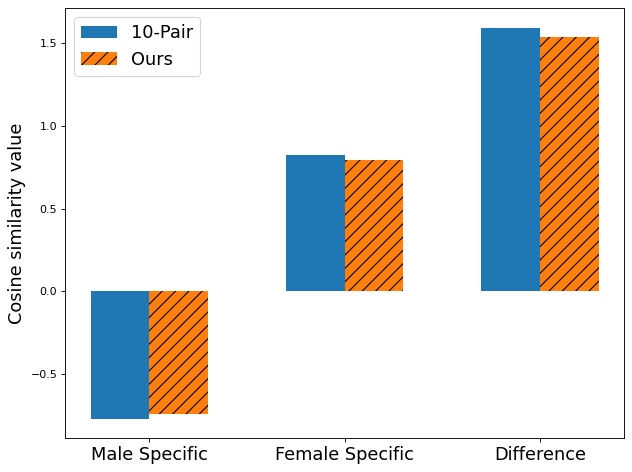

In [6]:
# Evaluate the quality of gender direciton in the GloVe word embedding space
old_d_male = {}
old_d_female = {}
for word in male_specific:
    similarity = simi(wv_glove[w2i_glove[word], :], old_gender_direction) 
    old_d_male[word] = similarity
for word in female_specific:
    similarity = simi(wv_glove[w2i_glove[word], :], old_gender_direction)
    old_d_female[word] = similarity
    
new_d_male = {}
new_d_female = {}
for word in male_specific:
    similarity = simi(wv_glove[w2i_glove[word], :], my_gender_direction) 
    new_d_male[word] = similarity
for word in female_specific:
    similarity = simi(wv_glove[w2i_glove[word], :], my_gender_direction)
    new_d_female[word] = similarity
    
old_avg = np.average(list(old_d_male.values()) + (list(old_d_female.values())))
old_std = np.std(list(old_d_male.values()) + (list(old_d_female.values())))

new_avg = np.average(list(new_d_male.values()) + (list(new_d_female.values())))
new_std = np.std(list(new_d_male.values()) + (list(new_d_female.values())))

old_female = np.average((list(old_d_female.values()) - old_avg) / old_std)
new_female = np.average((list(new_d_female.values()) - new_avg) / new_std)
old_male = np.average((list(old_d_male.values()) - old_avg) / old_std)
new_male = np.average((list(new_d_male.values()) - new_avg) / new_std)

figure(figsize=(8, 6), dpi=80)
  
X = ['Male Specific','Female Specific','Difference']
Yold = [old_male, old_female, abs(old_male - old_female)]
Znew = [new_male, new_female, abs(new_male-new_female)]
    
X_axis = np.arange(len(X))


  
plt.bar(X_axis - 0.15, Yold, 0.3, label = '10-Pair')
plt.bar(X_axis + 0.15, Znew, 0.3, label = 'Ours', hatch="//")
  
plt.xticks(X_axis, X, fontsize=16)
plt.ylabel("Cosine similarity value", fontsize=16)
plt.legend(fontsize=16)
plt.tight_layout()
# plt.savefig('../AAAI-21-debiasing/fig/gender_dir_glove.pdf')
plt.show()


In [7]:
old_gender_direction = doPCA(definitional_pairs, wv_dd, w2i_dd).components_[0]

my_gender_direction = sum([wv_dd[w_id, :] for w_id in female_ids]) / len(female_ids) - sum([wv_dd[w_id, :] for w_id in male_ids]) / len(male_ids)

pairs used in PCA:  10


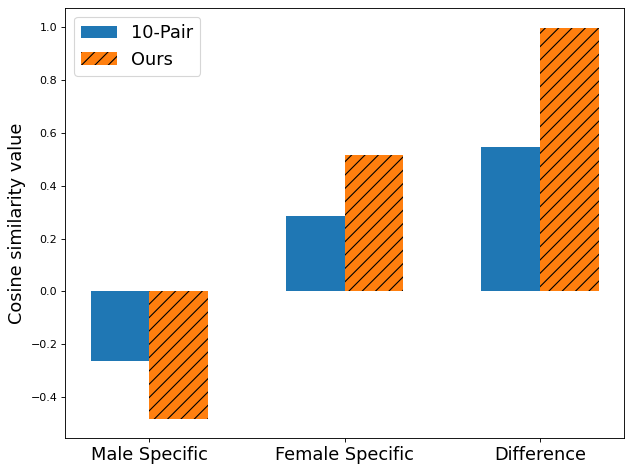

In [8]:
# Evaluate the quality of gender direciton in the DD-GloVe word embedding space
old_d_male = {}
old_d_female = {}
for word in male_specific:
    similarity = simi(wv_dd[w2i_dd[word], :], old_gender_direction) 
    old_d_male[word] = similarity
for word in female_specific:
    similarity = simi(wv_dd[w2i_dd[word], :], old_gender_direction)
    old_d_female[word] = similarity
    
new_d_male = {}
new_d_female = {}
for word in male_specific:
    similarity = simi(wv_dd[w2i_dd[word], :], my_gender_direction) 
    new_d_male[word] = similarity
for word in female_specific:
    similarity = simi(wv_dd[w2i_dd[word], :], my_gender_direction)
    new_d_female[word] = similarity
    
old_avg = np.average(list(old_d_male.values()) + (list(old_d_female.values())))
old_std = np.std(list(old_d_male.values()) + (list(old_d_female.values())))

new_avg = np.average(list(new_d_male.values()) + (list(new_d_female.values())))
new_std = np.std(list(new_d_male.values()) + (list(new_d_female.values())))

old_female = np.average((list(old_d_female.values()) - old_avg) / old_std)
new_female = np.average((list(new_d_female.values()) - new_avg) / new_std)
old_male = np.average((list(old_d_male.values()) - old_avg) / old_std)
new_male = np.average((list(new_d_male.values()) - new_avg) / new_std)

figure(figsize=(8, 6), dpi=80)
  
X = ['Male Specific','Female Specific','Difference']
Yold = [old_male, old_female, abs(old_male - old_female)]
Znew = [new_male, new_female, abs(new_male-new_female)]
    
X_axis = np.arange(len(X))
  
plt.bar(X_axis - 0.15, Yold, 0.3, label = '10-Pair')
plt.bar(X_axis + 0.15, Znew, 0.3, label = 'Ours', hatch="//")
  
plt.xticks(X_axis, X, fontsize=16)
plt.ylabel("Cosine similarity value", fontsize=16)
plt.legend(fontsize=16)
plt.tight_layout()
# plt.savefig('../AAAI-21-debiasing/fig/gender_dir_dd.pdf')
plt.show()